In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import random
sns.set()

import pandas as pd # esto para poner tablas numericas

# P1

de [La documentación de Python](https://docs.python.org/3/library/random.html)

Almost all module functions depend on the basic function random(), which generates a random float uniformly in the semi-open range [0.0, 1.0). Python uses the Mersenne Twister as the core generator. It produces 53-bit precision floats and has a period of 2**19937-1. The underlying implementation in C is both fast and threadsafe. The Mersenne Twister is one of the most extensively tested random number generators in existence. However, being completely deterministic, it is not suitable for all purposes, and is completely unsuitable for cryptographic purposes.

En resumen, la función $\text{random.random()}$ genera un número pseudo aleatorio uniforme en $[0,1]$, de forma de que:
* El número posee 53 bits de precisión.
* Posee un periodo de $2^{19937}-1$.
* Lo logra usando el método __Mersenne Twister__.

Para cambiar la semilla, se utiliza el comando $\text{random.seed(semilla)}$, que recibe un entero y configura la forma en que se genera el número aleatorio.

Una forma astuta de setear la semilla es utilizar un número entero generado por variables externas al computador, como por ejemplo el tiempo en que se ejecuta el código.

**falta explicar algo del método _mersenne twister_ ?**
se podría ver la wikipedia jeje
https://es.wikipedia.org/wiki/Mersenne_twister
https://es.wikipedia.org/wiki/N%C3%BAmero_primo_de_Mersenne

# P2

## Parte 1: 

Se calculan las varianzas teóricas de

$$ X = \sqrt{1-U^2},\quad Z = 1_{\{U_1^2+U_2^2 \leq 1\}},$$ 
con $U,U_1,U_2$ variables uniformes en $[0,1]$ independientes.

----

Para $\mathbb V(X)$, se separa la varianza,
$$ \mathbb V(X) = E(X^2) - E(X)^2 $$
Se usa el hecho de que,
$$ X^2 = 1-U^2 $$
Luego,
$$ \mathbb V(X) = 1-E(U^2) - E(\sqrt{1-U^2})^2$$
Se calcula individualmente las esperanzas,

$$ \begin{matrix}E\left(\sqrt{1-U^2}\right) & = & \int_0^1 \sqrt{1-x^2} f_U(x)\ dx = \int_0^1 \sqrt{1-x^2} \ dx \underset{enunciado}{=} I = \frac{\pi}{4}, \\ E(U^2) & = & E(U^2) - E(U)^2 + E(U)^2 = \mathbb V(U) + E(U)^2 = \frac{(1-0)^2}{12} + \frac{1}{4} = \frac{1+3}{12} = \frac{1}{3}.  \end{matrix}   $$

$$ \mathbb V(X) =  1- \frac{1}{3} - \frac{\pi^2}{16} \approx 0.0498$$

----

Para $\mathbb V(Z)$ es más simple, se utiliza el hecho de que el cuadrado de una indicatriz es ella misma.

$$\mathbb V(Z) = E((1_{U_1^2+U_2^2 \leq 1})^2) - E(Z)^2 = E(Z) - E(Z)^2 \underset{enunciado}{=} \frac{\pi}{4} - \frac{\pi^2}{16} = \pi\frac{4-\pi}{16} \approx 0,1685. $$

### Simulemos las varianzas

Para simular las varianzas se definen las funciones $X(U)$ y $Z(U,V)$ que permiten describir las variables de $X$ y $Z$ en términos de variables uniformes $U$ y $V$.

Luego, para un arreglo de distintos $n$'s se generan variables uniformes y se aplican las funciones $X(U)$ y $Z(U,V)$ calculando su varianza mediante la función integrada $np.var()$.

In [8]:
### Definamos nuestras variables aleatorias

def X(u): return np.sqrt(1 - u**2)

# np.where nos permite trabajar sin if's y con arrays
def Z(u, v): return np.where(u**2 + v**2 <= 1, 1, 0)

### Calculemos las varianzas para distintos n's

n = np.arange(10, 10100, 10)
varX = np.zeros(len(n))
varZ = np.zeros(len(n))

for i in range(len(n)):
    U = np.random.uniform(size=n[i])
    V = np.random.uniform(size=n[i])
    np.random.seed(123*i)

    # estimamos la varianza mediante un estimador no sesgado

    XX = X(U)
    ZZ = Z(U, V)

    varX[i] = np.var(XX, ddof=1) # ddof=1 equivale a dividir por n-1
    varZ[i] = np.var(ZZ, ddof=1)

###Varianzas teóricas para X y Z
varX_teo = (2/3) - np.pi**2/16
varZ_teo = np.pi/4 - (np.pi / 4)**2


Se obtienen los siguientes gráficos a partir de las simulaciones realizadas, donde además se presenta el valor teórico de las varianzas asociadas a ambas variables aleatorias.

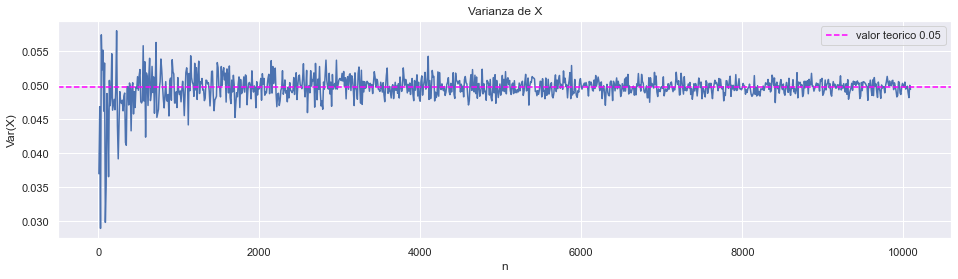

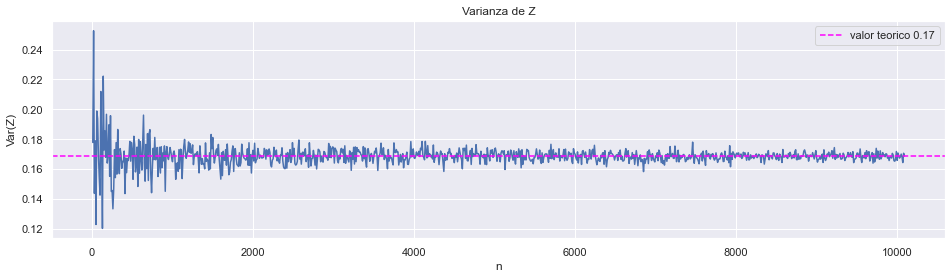

In [9]:

### Gráfico Varianza de X para simulaciones de distintos n's
plt.figure(0, figsize=(16, 4))
plt.plot(n, varX)
plt.xlabel('n')
plt.ylabel('Var(X)')
plt.axhline(varX_teo, color='magenta', linestyle='--', label='valor teorico {:.2f}'.format(varX_teo))
plt.legend()
plt.title('Varianza de X')
plt.show()

### Gráfico Varianza de Z para simulaciones de distintos n's
plt.figure(1, figsize=(16, 4))
plt.plot(n, varZ)
plt.xlabel('n')
plt.ylabel('Var(Z)')
plt.axhline(varZ_teo, color='magenta', linestyle='--', label='valor teorico {:.2f}'.format(varZ_teo))
plt.legend()
plt.title('Varianza de Z')
plt.show()


Es posible observar que para ambas variables aleatorias, a medida que aumenta la cantidad de réplicas utilizadas en la simulación, la varianza empírica se acerca más a la teórica. Sin embargo, la simulación siempre presenta un error respecto a la teórica.

### Obtengamos '$n$' tal que el error sea menor a 1% 

Para estimar la cantidad de réplicas necesarias, se considera el error de aproximación como

$$Err(\cdot,n)=\frac{\mathbb V(\cdot)-\mathbb V_{e}(\cdot,n)}{\mathbb V(\cdot)}$$

donde $\mathbb V(\cdot)$ corresponde a la varianza teórica de una variable aleatoria, y $\mathbb V_{e}(\cdot,n)$ corresponde a su varianza empírica para una simulación de $n$ réplicas.

Así, se busca el primer $n$ tal que $Err(\cdot,n))<=0.01$.

In [10]:
for i in range(len(n)):
    if np.abs((varX_teo - varX[i])/varX_teo) <= 0.01:
        nn_x = n[i]
        break

for i in range(len(n)):
    if np.abs((varZ_teo - varZ[i])/varZ_teo) <= 0.01:
        nn_z = n[i]
        break

print('En las realizaciones hechas se necesita al menos')
print()
print('un n = {} para simular X'.format(nn_x) +' con un error menor al 1%')
print()
print('un n = {} para Z'.format(nn_z) +' con un error menor al 1%')

En las realizaciones hechas se necesita al menos

un n = 220 para simular X con un error menor al 1%

un n = 80 para Z con un error menor al 1%


## Parte 2: 
### Calcular $n$ para aproximar $I$ con diferentes errores y probabilidades

Para estimar la cantidad de réplicas necesarias que se requieren para aproximar $I$ con un error máximo ${Err}_{i}$ y probabilidad ${Pr}_{i}$ para $i=1,2,3$ consideramos

$$n\geq\frac{\sigma^2Z_{\alpha /2}^2}{\epsilon^2}$$

donde $\sigma^2$ corresponde a la varianza teórica de la variable aleatoria  considerada, $Z_{\alpha /2}$ al *score* de la distribución normal para $\alpha/2$, donde $\alpha=1-Pr$, y $\epsilon$ corresponde a $Err$.




In [11]:
Err1 = 0.1 ; Pr1 = 0.9 ; Z010 = sp.stats.norm.ppf(Pr1)
Err2 = 0.01 ; Pr2 = 0.95 ; Z005 = sp.stats.norm.ppf(Pr2)
Err3 = 0.001 ; Pr3 = 0.99 ; Z001 = sp.stats.norm.ppf(Pr3)

n_x_1 = (varX_teo*Z010 / Err1)**2
n_x_2 = (varX_teo*Z005 / Err2)**2
n_x_3 = (varX_teo*Z001 / Err3)**2

n_z_1 = (varZ_teo*Z010 / Err1)**2
n_z_2 = (varZ_teo*Z005 / Err2)**2
n_z_3 = (varZ_teo*Z001 / Err3)**2 

data = {'Error': [Err1, Err2, Err3], 'Prob': [Pr1, Pr2, Pr3],'X': np.round([n_x_1, n_x_2, n_x_3], 2), 'Z': np.round([n_z_1, n_z_2, n_z_3], 2)}
NN = pd.DataFrame(data)
NN

,Error,Prob,X,Z
0,0.100,0.90,0.41,4.67
1,0.010,0.95,67.14,768.60
2,0.001,0.99,13430.55,153743.21


## Parte 3: 
### Aproximar $E(X)$ y $E(Z)$ usando diferentes replicas hasta llegar a $n^*$

In [12]:
# Ocupamos el metodo de Monte Carlo
import time

nx = np.arange(50, int(n_x_3), step=100)
nz = np.arange(50, int(n_z_3), step=100)

expectation_X = np.zeros(len(nx))
tiempo_x = np.zeros(len(nx))

expectation_Z = np.zeros(len(nz))
tiempo_z = np.zeros(len(nz))

for i in range(len(nx)):

    np.random.seed(364 + 43*i)
    start = time.time()
    U = np.random.uniform(size=nx[i])
    XX = X(U)

    expectation_X[i] = np.mean(XX)
    end = time.time()
    tiempo_x[i] = end - start

for i in range(len(nz)):

    np.random.seed(3*i)
    start = time.time()
    U = np.random.uniform(size=nz[i])
    V = np.random.uniform(size=nz[i])
    ZZ = Z(U, V)

    expectation_Z[i] = np.mean(ZZ)
    end = time.time()
    tiempo_z[i] = end - start


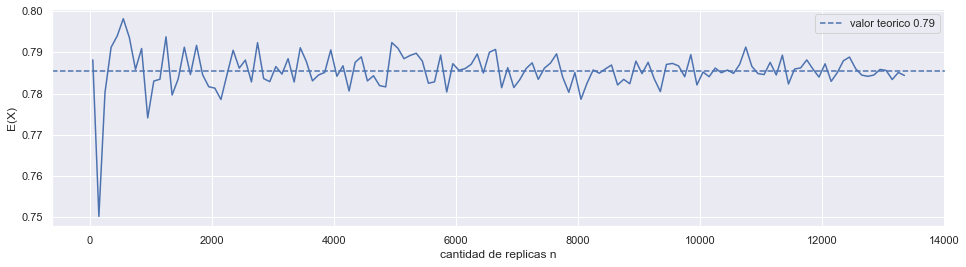

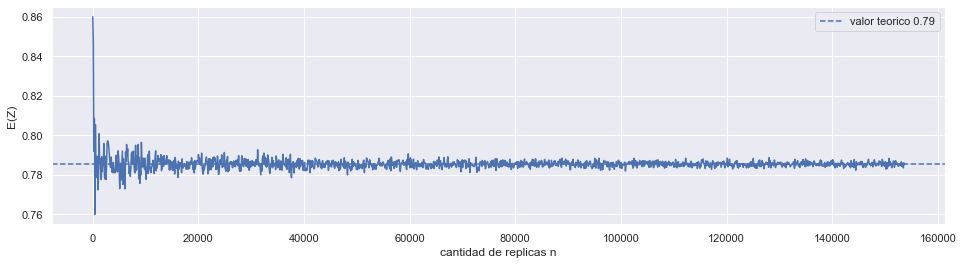

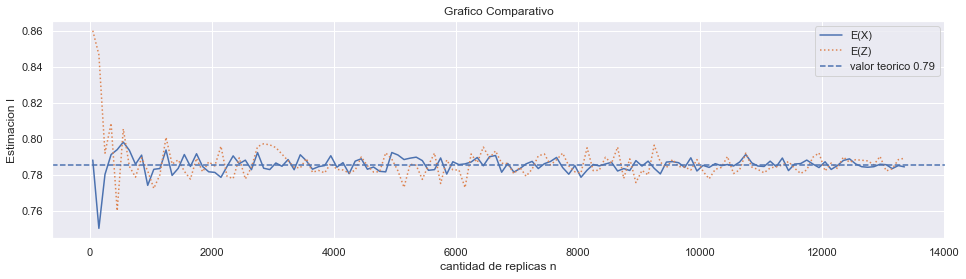

In [13]:
### Ploteo de Esperanzas hasta valor n*

plt.figure(2, figsize=(16, 4))
plt.plot(nx, expectation_X)
plt.xlabel('cantidad de replicas n')
plt.ylabel('E(X)')
plt.axhline(np.pi / 4, linestyle='--', label='valor teorico {:.2f}'.format(np.pi / 4))
plt.legend()
plt.show()

plt.figure(3, figsize=(16, 4))
plt.plot(nz, expectation_Z)
plt.xlabel('cantidad de replicas n')
plt.ylabel('E(Z)')
plt.axhline(np.pi / 4, linestyle='--', label='valor teorico {:.2f}'.format(np.pi / 4))
plt.legend()
plt.show()

plt.figure(4, figsize=(16, 4))
plt.plot(nx, expectation_X, label='E(X)')
plt.plot(nx, expectation_Z[:len(nx)], label='E(Z)', linestyle='dotted')
plt.xlabel('cantidad de replicas n')
plt.ylabel('Estimacion I')
plt.title('Grafico Comparativo')
plt.axhline(np.pi / 4, linestyle='--', label='valor teorico {:.2f}'.format(np.pi / 4))
plt.legend()
plt.show()

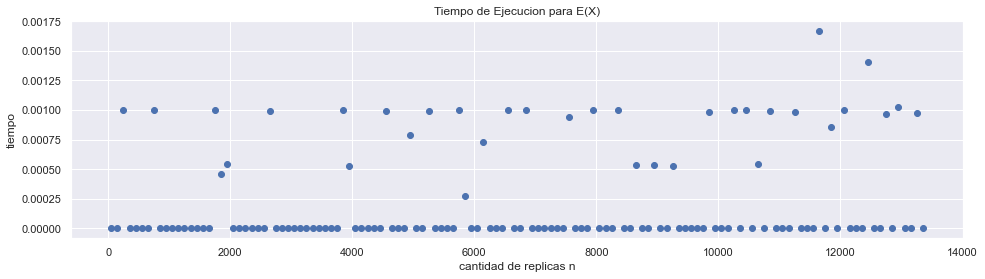

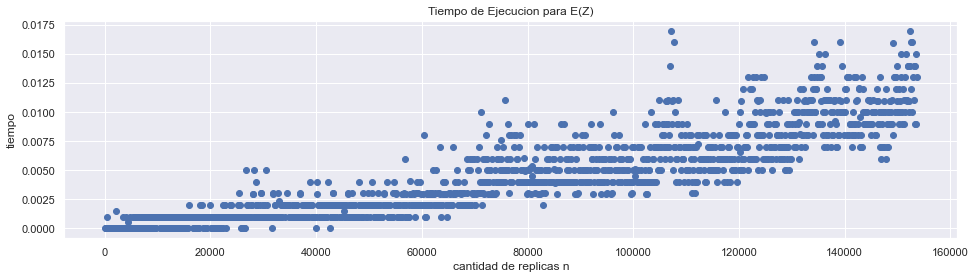

In [14]:
### Ploteo de Tiempos de Ejecucion de E(X), E(Z)) hasta valor n*

plt.figure(5, figsize=(16, 4))
plt.plot(nx, tiempo_x, 'o')
plt.xlabel('cantidad de replicas n')
plt.ylabel('tiempo')
plt.title('Tiempo de Ejecucion para E(X)')
plt.show()

plt.figure(6, figsize=(16, 4))
plt.plot(nz, tiempo_z, 'o')
plt.xlabel('cantidad de replicas n')
plt.ylabel('tiempo')
plt.title('Tiempo de Ejecucion para E(Z)')
plt.show()

In [36]:
plt.plot(tiempo_x)

array([0.00100183, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

# P3
## Parte 1:

In [25]:
def DiscreteQuantile(f, u):
    """
    params
    f:  funcion de masa discreta (debe retornar un float)
    u:  vector en [0, 1]^r

    return menor vector n tal que \sum_{j=0}^{n_i} f(j) \geq u_i
    """

    n = np.zeros(len(u))

    for i in range(len(u)):
        n_i = 0

        while np.sum(f(np.arange(n_i+1))) < u[i]:
            n_i += 1

        n[i] = n_i

    return n

f = lambda x: 10*np.ones(len(x))
u = 25*np.ones(5)
u[3] = 70

DiscreteQuantile(f, u)

array([2., 2., 2., 6., 2.])

## Parte 2

In [26]:
def DiscreteQuantileF(F, u):
    """
    params
    F:     funcion de distribucion
    u:     vector en [0, 1]^r

    return menor vecto 'n' en [0, 1]^r tal que F(n_i) \geq u_i
    """

    n = np.zeros(len(u))

    for i in range(len(n)):
        n_i = 0

        while F(n_i) < u[i]:
            n_i += 1

        n[i] = n_i
    return n

## Parte 3

In [27]:
def ContinuousQuantile(F,f,u, error=1e-4):
    """
    Metodo que retorna 'x' tal que |F(x_i) - u_i|\leq error
    ocupando el metodo de Newton.

    params
    F:     funcion de distribucion
    f:     funcion de densidad de F
    u:     vector en [0, 1]^r

    return 'x' tal que |F(x_i) - u_i|\leq error
    """
    r = len(u)
    x = np.zeros(r)
    for i in range(r):
        x_i = 0.5
        while True:
            if abs(F(x_i)-u[i]) <= error:
                break
            else:
                x_i -= (F(x_i)-u[i])/f(x_i)
        x[i] = x_i 
    return x

## Parte 4


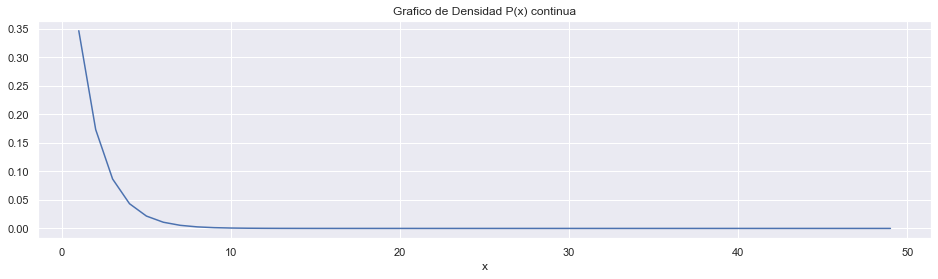

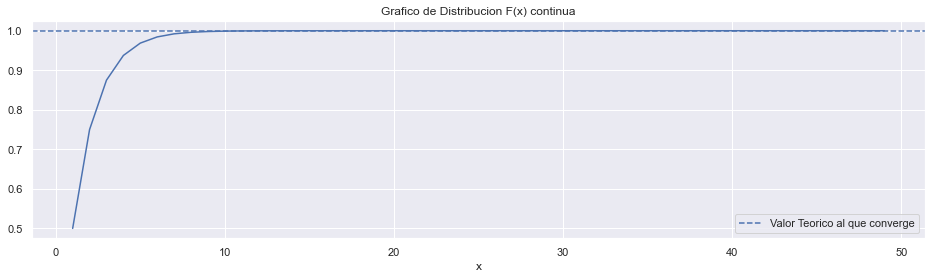

In [28]:



import math

def densidad(j): return (j>=1)*(0.5)**j #0.5*np.ones(len(j)))**j #



def densidad_cont(x):return np.log(2)*(0.5**x)
    # if type(x) == float or type(x) == int or type(x) == np.float64:
    #     return 0.5**math.ceil(x)
    # else:
    #     return (0.5)**np.ceil(x)

def distribucion(x): return (1 - (1/2)**x)

    # j = np.ceil(x)

    # if type(j) == int or type(j) == np.float64:     # caso escalar
    #     return np.sum((0.5)**np.arange(1, j+1))
    # else:                                           # caso vectorial

    #     vector = np.zeros(len(j))

    #     for i in range(len(vector)):
    #         vector[i] = np.sum((0.5)**np.arange(1, j[i] + 1))

    #     return vector

x = np.arange(1, 50)
distribucion(x)

plt.figure(7, figsize=(16,4))
plt.plot(x, densidad_cont(x))
plt.title('Grafico de Densidad P(x) continua')
plt.xlabel('x')
plt.show()

plt.figure(8, figsize=(16,4))
plt.plot(x, distribucion(x))
plt.title('Grafico de Distribucion F(x) continua')
plt.axhline(1, label='Valor Teorico al que converge', linestyle='--')
plt.xlabel('x')
plt.legend()
plt.show()

In [29]:
# def densidad_exp(x): return np.exp(-x)

# def distribucion_exp(x): return 1 - np.exp(-x)

# U = np.random.uniform(size=1000)

# X = DiscreteQuantile(densidad_exp, U)

# XX = DiscreteQuantileF(distribucion_exp, U)

#  = ContinuousQuantile(distribucion_exp, densidad_exp, U)

# #plt.plot(XX)
# #plt.plot(XX, U)
# #plt.hist(X)

# # def DiscreteQuantile(f,u):
# #     r = len(u)
# #     N = np.zeros(r,dtype=int)
    
# #     ## Método de fuerza bruta por suma acumulada.
# #     # inicia i en 0, irá creciendo más adelante
# #     # en cada iteración, agranda n_i y se detiene cuando
# #     # suma(j=0,...,n_i, f(j)) >= u(i)
# #     # aquí se agrega n_i a N[i] y se reinicia el proceso
# #     # para i más grande.
    
# #     i = 0
# #     n_i = 0
# #     suma_acumulada = 0
# #     while(i<r):
# #         suma_acumulada += f(n_i)
# #         if (suma_acumulada >= u[i]):
# #             # encontramos al primer elemento que cumple,
# #             # agregamos el valor y reiniciamos el proceso para i+1.
            
# #             N[i] = n_i
            
# #             i = i+1
# #             n_i = 0
# #             suma_acumulada = 0
# #         else:
# #             n_i = n_i+1
# #         pass
# #     return N
# # # ojo: no olvidar que es sum(f(j) for j in range(0,N[i]+1)) >= u[i]
# plt.figure(figsize=(8,6))
# plt.hist(X, alpha=0.5, label="data1")
# plt.hist(XX, alpha=0.5, label="data2")
# plt.hist(XX, alpha=0.5, label="data3")


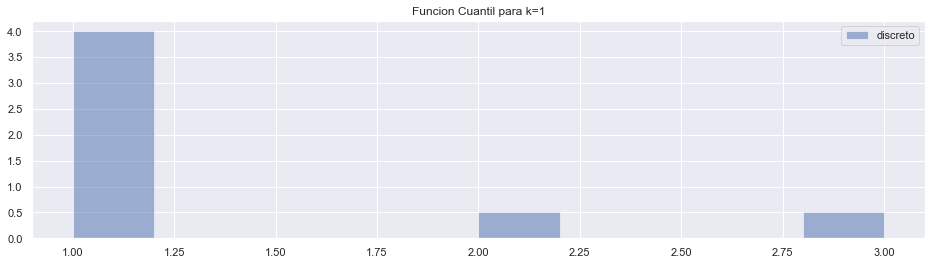

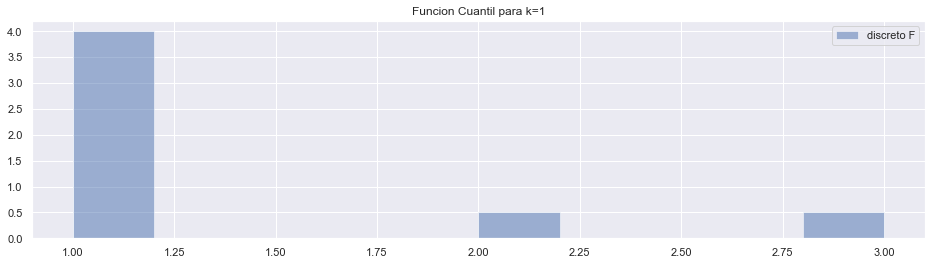

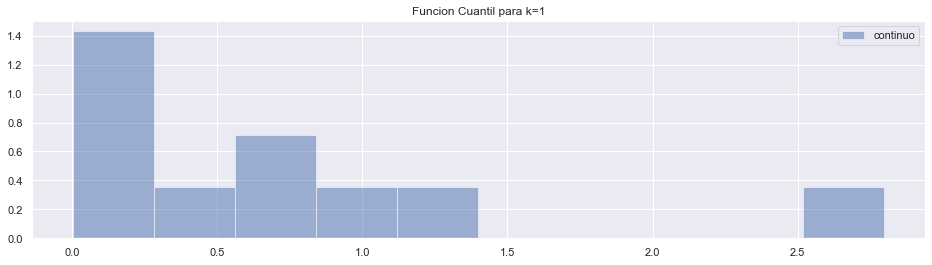

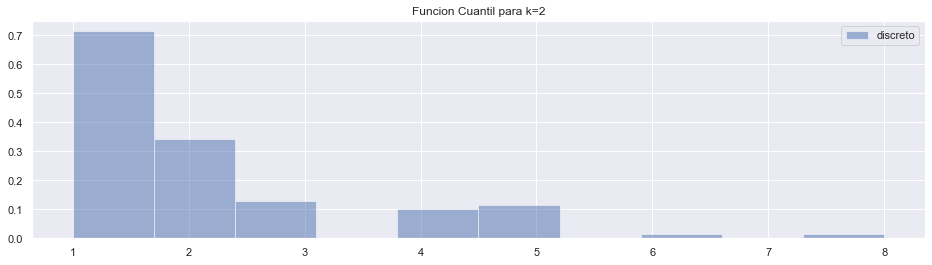

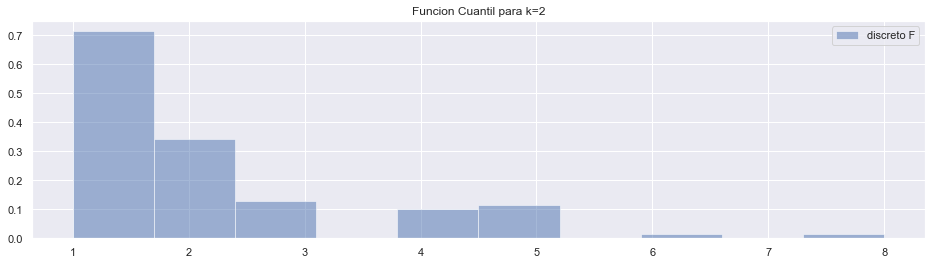

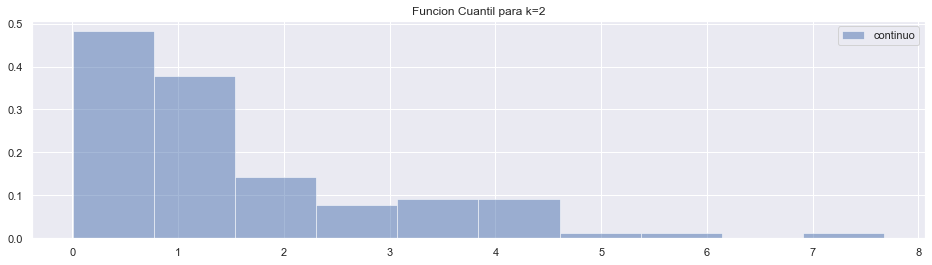

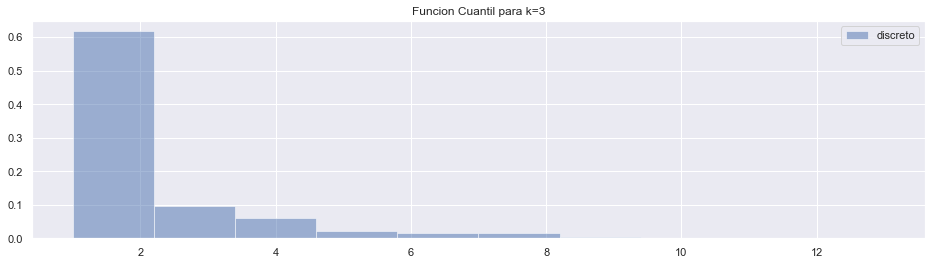

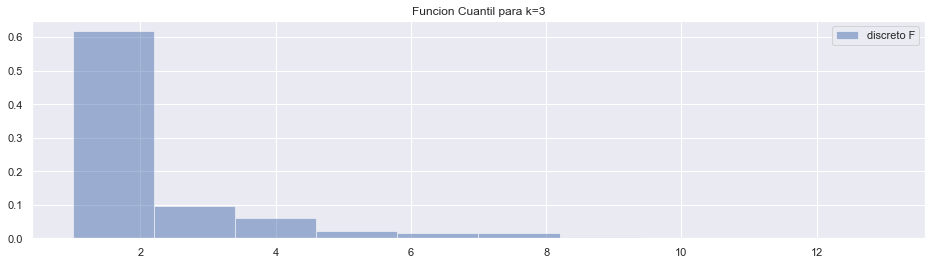

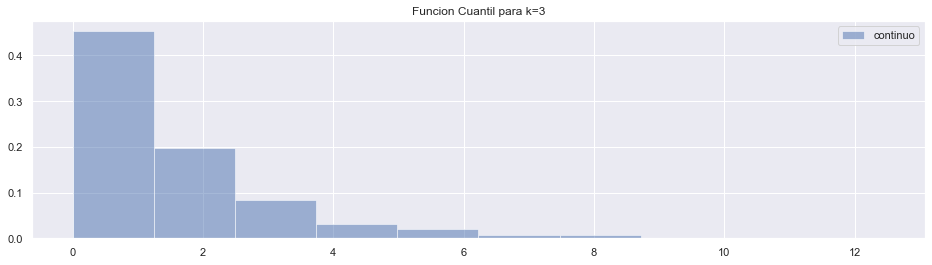

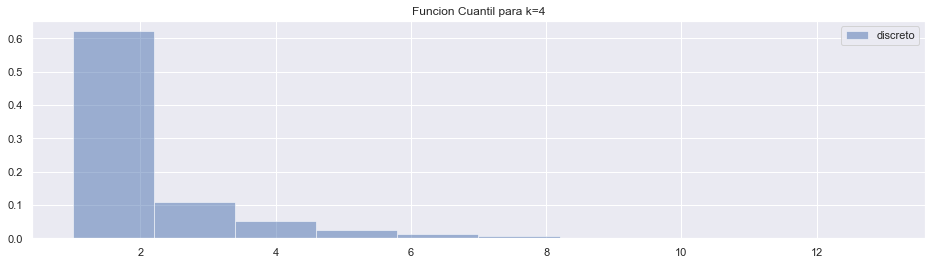

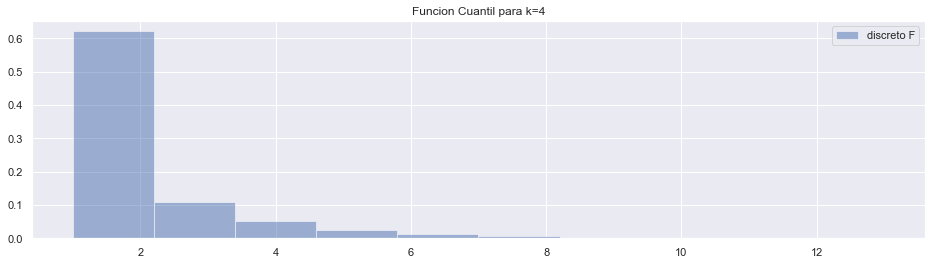

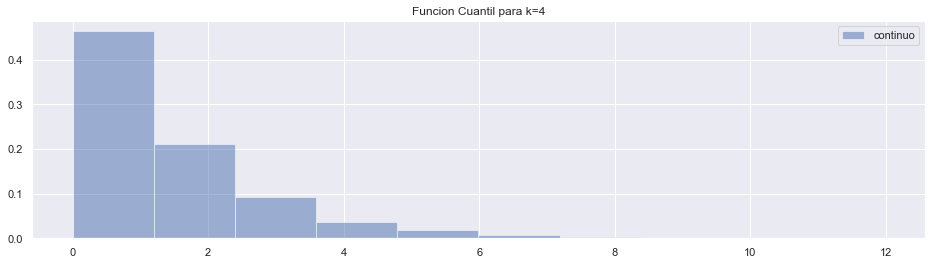

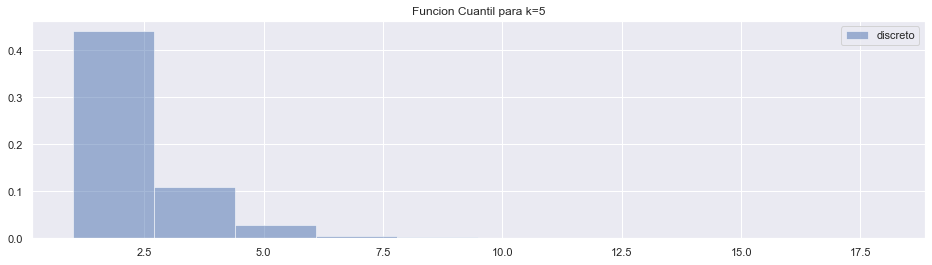

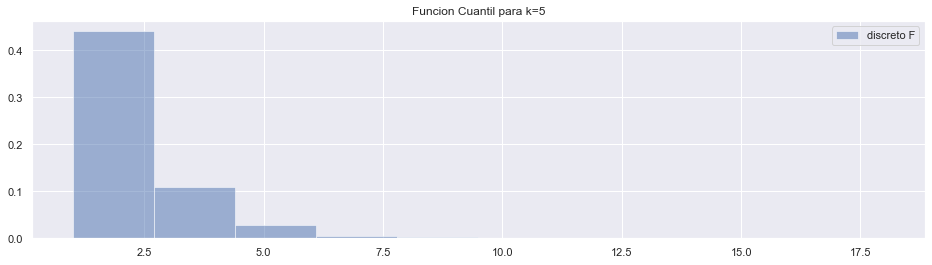

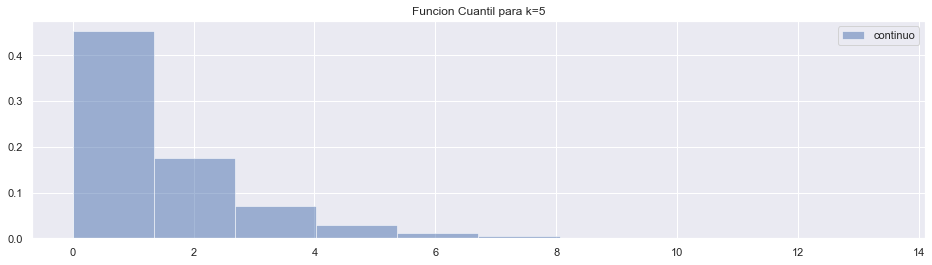

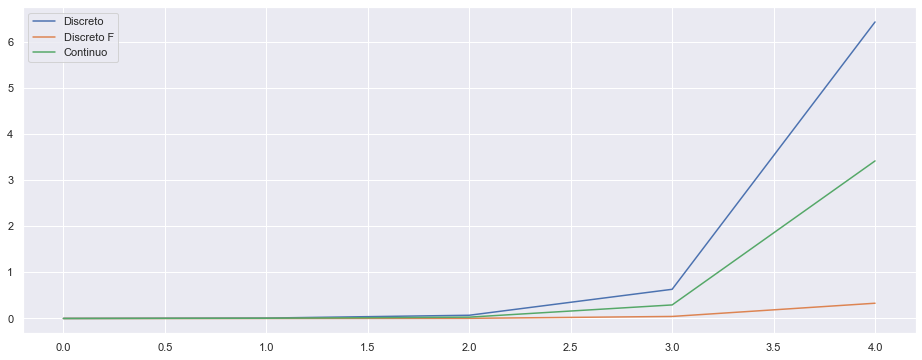

[1.00135803e-04 9.00340080e-05 7.00047016e-05 6.33301973e-05
 6.43590689e-05]


In [30]:
t1 = np.zeros(5)

t2 = np.zeros(5)

t3 = np.zeros(5)

for k in np.arange(1, 6):
    n = 10**k

    U = np.random.uniform(size=n)
    np.random.seed(k*12)

    start = time.time()
    cuantil_discreto = DiscreteQuantile(densidad, U)
    end = time.time()
    t1[k-1] = end - start

    start = time.time()
    cuantil_discreto_F = DiscreteQuantileF(distribucion, U)
    end = time.time()
    t2[k-1] = end - start

    start = time.time()
    cuantil_continuo = ContinuousQuantile(distribucion, densidad_cont, U)
    end = time.time()
    t3[k-1] = end - start

    plt.figure(8+k, figsize=(16, 4))
    plt.hist(cuantil_discreto, alpha=0.5, label='discreto', density='True')
    plt.title('Funcion Cuantil para k={}'.format(k))
    plt.legend()
    plt.show()

    plt.figure(9+2*k, figsize=(16, 4))
    plt.hist(cuantil_discreto_F, alpha=0.5, label = 'discreto F', density='True')
    plt.title('Funcion Cuantil para k={}'.format(k))
    plt.legend()
    plt.show()

    plt.figure(10+3*k, figsize=(16, 4))
    plt.hist(cuantil_continuo, alpha=0.5, label='continuo', density='True')
    plt.title('Funcion Cuantil para k={}'.format(k))
    plt.legend()
    #plt.xlabel('cantidad de replicas n')
    #plt.ylabel('$Q \circ F^{-1}$')
    #plt.title('Cuantiles para')
    plt.show()

plt.figure(11, figsize=(16, 6))
plt.plot(t1, label='Discreto')
plt.plot(t2, label='Discreto F')
plt.plot(t3, label='Continuo')
plt.legend()
plt.show()

kk = np.arange(1, 6)
nn = 10**kk
print(t1 / nn)

#data = {'Discreto': acep_rech_discreto, 'Tiempo Discreto': t1, 'DiscretoF': acep_rech_discreto_F, 'Tiempo DiscretoF': t2,'Continuo': acep_rech_continuo, 'Tiempo Continuo': t3}

#aceptacion_rechazo = pd.DataFrame(data)

#acep_rech_continuo

In [31]:
kk = np.arange(1, 6)
nn = 10**kk
print(t1 / nn)
print(t2 / nn)
print(t3 / nn)

[1.00135803e-04 9.00340080e-05 7.00047016e-05 6.33301973e-05
 6.43590689e-05]
[0.00000000e+00 9.98973846e-06 3.00025940e-06 4.40003872e-06
 3.31009150e-06]
[0.00000000e+00 5.00035286e-05 2.90014744e-05 2.94020653e-05
 3.41986060e-05]


## Parte 5

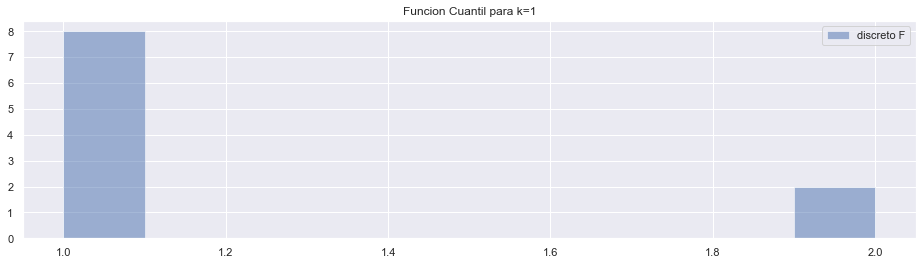

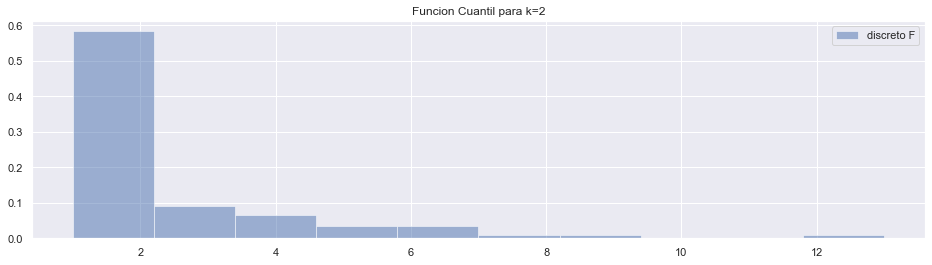

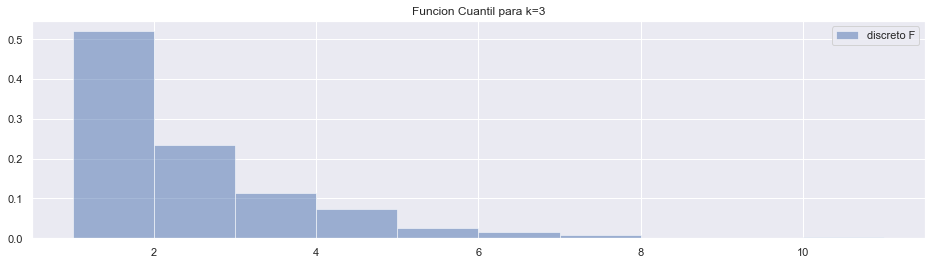

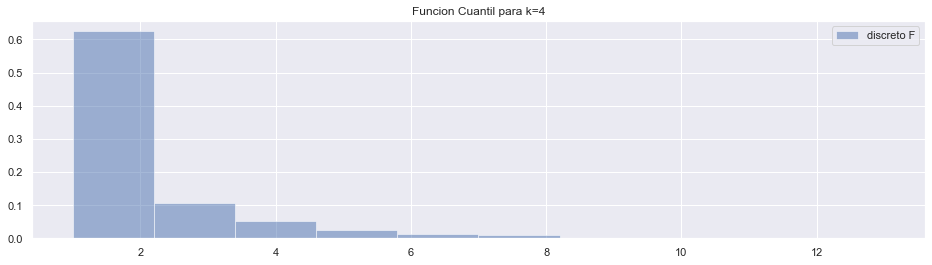

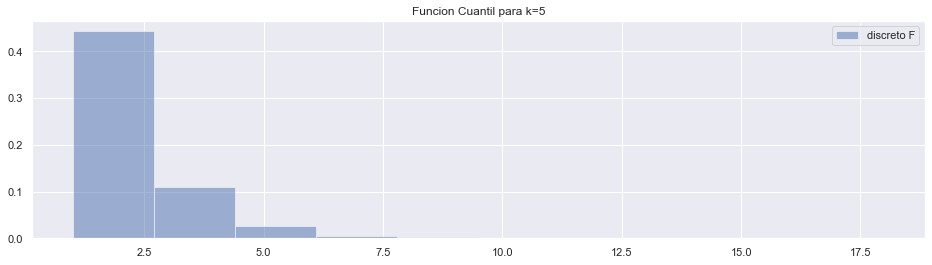

In [32]:
cuantiles = []

for k in np.arange(1, 6):
    n = 10**k

    U = np.random.uniform(size=n)
    np.random.seed(2*k*12)

    start = time.time()
    cuantil_discreto_F = DiscreteQuantileF(distribucion, U)
    end = time.time()
    t2[k-1] = end - start

    cuantiles.append(cuantil_discreto_F)

    plt.figure(9+2*k, figsize=(16, 4))
    plt.hist(cuantil_discreto_F, alpha=0.5, label = 'discreto F', density='True')
    plt.title('Funcion Cuantil para k={}'.format(k))
    plt.legend()
    plt.show()

    #plt.xlabel('cantidad de replicas n')
    #plt.ylabel('$Q \circ F^{-1}$')
    #plt.title('Cuantiles para')
    plt.show()

#data = { 'Resultado k=1': cuantiles[0], 'Resultado k=2': cuantiles[1], 'Resultado k=3': cuantiles[2], 'Resultado k=4': cuantiles[3], 'Resultado k=5': cuantiles[4]}

#df = pd.DataFrame(data)
#df.describe()



In [33]:
varianzas = np.zeros(5)
medias = np.zeros(5)
for i in range(5):
    varianzas[i] = cuantiles[i].var()
    medias[i] = cuantiles[i].mean()

data = {'varianzas muestrales': varianzas, 'medias muestrales': medias}
print(pd.DataFrame(data, index=np.arange(1, 6)))
print('Valor teorico: Media = 2        Varianza = 2')

   varianzas muestrales  medias muestrales
1              0.160000            1.20000
2              3.773100            2.37000
3              1.977216            1.97200
4              1.931458            1.99350
5              1.988579            1.99098
Valor teorico: Media = 2        Varianza = 2


# P4

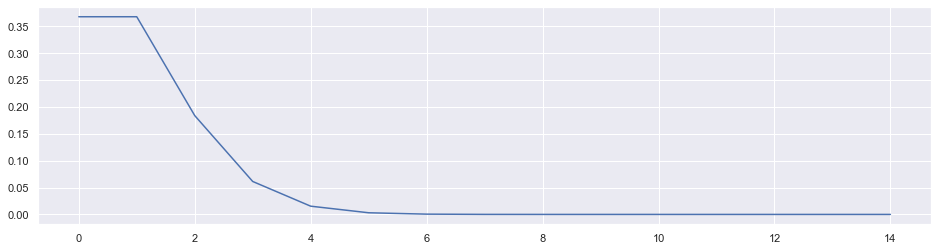

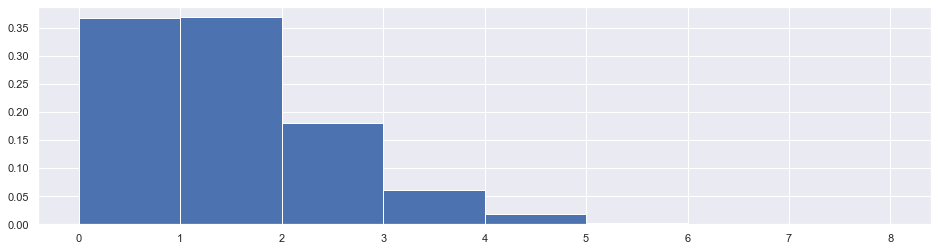

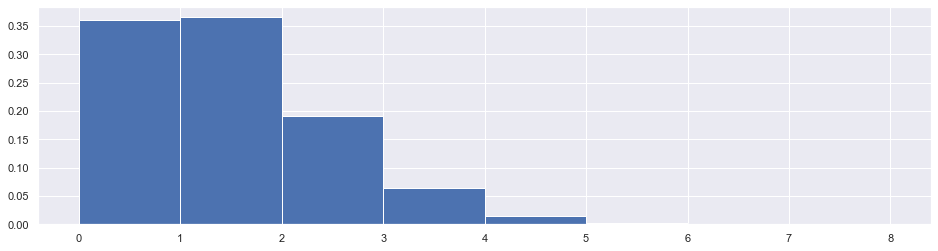

In [34]:
def densidad(k, lambd=1, s=8):

    #if type(k) == int:
    numerador = np.exp(-lambd)*lambd**k / np.math.factorial(k)
    denominador = 0

    for j in range(s+1):
        denominador += np.exp(-lambd)* lambd**j / np.math.factorial(j)

    return numerador / denominador


k = np.arange(15)
d = [densidad(i) for i in k]
plt.figure(figsize=(16, 4))
plt.plot(k, d)
plt.show()

s = 8
lamb = 1
n = 10000
Y_N = []

while len(Y_N) < n:
    Y = np.random.randint(0, s)
    U = np.random.uniform()
    if U <= densidad(Y):
        Y_N.append(Y)

def poisson_unif(lamb=1):

    N = -1
    suma = 0
    while suma < lamb:
        U = np.random.uniform()
        suma += -np.log(U)
        N += 1
    return N

P_N = []
while len(P_N) < n:
    Y = poisson_unif()
    U = np.random.uniform()
    if U <= densidad(Y)* np.math.factorial(Y) / (np.exp(-lamb) * lamb**Y) :
        P_N.append(Y)

plt.figure(figsize=(16, 4))
plt.hist(Y_N, bins=np.arange(9), density='True')
plt.show()

plt.figure(figsize=(16, 4))
plt.hist(P_N, bins=np.arange(9), density='True')
plt.show()

(array([371., 365., 178.,  63.,  18.,   5.,   0.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 &lt;a list of 8 Patch objects&gt;)

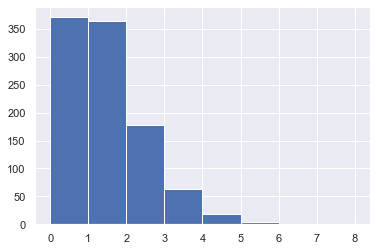

In [82]:

plt.hist(Y_N, bins=np.arange(9))

In [35]:
%timeit [num for num in range(20)]

1.92 µs ± 53.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
